In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# LP formulation for a discrete graph search


In [9]:
n = 3
solve_integer = False  # Set to True for to solve as an integer program

# Vertex coordinates and indexing 
tile_coords = [(i, j) for i in range(n) for j in range(n)]
V = len(tile_coords)
idx = {coord: k for k, coord in enumerate(tile_coords)}

# Directed edges and costs (Euclidean distance)
edge_list = [
    ((0,0),(1,0)), ((1,0),(2,0)), ((2,0),(2,1)),
    ((0,1),(0,0)), ((0,1),(0,2)),
    ((1,1),(1,0)), ((1,1),(0,1)), ((1,1),(1,2)),
    ((2,1),(1,1)), ((2,1),(2,2)),
    ((1,2),(0,2)), ((1,2),(2,2)),
]
E = len(edge_list)
costs = np.array([np.linalg.norm(np.array(to)-np.array(frm))
                  for frm,to in edge_list])

start = (0,0)
goal  = (n-1,n-1)

# ===================================================================
# 1. Decision variable
# ===================================================================
x_e = cp.Variable(E, boolean=solve_integer, name="x_e")

# ===================================================================
# 2. Build objective and constraints
# ===================================================================
objective = cp.Minimize(costs @ x_e)
constraints = []

# Flow conservation at each node
for coord in tile_coords:
    inflow  = sum(x_e[i] for i,(frm,to) in enumerate(edge_list) if to == coord)
    outflow = sum(x_e[i] for i,(frm,to) in enumerate(edge_list) if frm == coord)
    if coord == start:
        constraints.append(outflow - inflow == 1)
    elif coord == goal:
        constraints.append(inflow - outflow == 1)
    else:
        constraints.append(outflow - inflow == 0)

# LP bounds (if not integer)
if not solve_integer:
    constraints += [x_e >= 0, x_e <= 1]

# ===================================================================
# 3. Solve
# ===================================================================
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.MOSEK, verbose=True)

print("Optimal objective value:", result)
print("Edge variables x_e:", x_e.value)


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 23 06:07:36 PM: Your problem has 12 variables, 33 constraints, and 0 parameters.
(CVXPY) Apr 23 06:07:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 23 06:07:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 23 06:07:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 23 06:07:36 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 23 06:07:36 PM: Compiling problem (target solver=MOSEK).
(C

# Extension to GCS


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 23 05:27:42 PM: Your problem has 51 variables, 120 constraints, and 0 parameters.
(CVXPY) Apr 23 05:27:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 23 05:27:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 23 05:27:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 23 05:27:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 23 05:27:42 PM: Compiling problem (target solver=MOSEK).
(

/home/srirangamrh/stuff/mobile_robotics/.venv/lib/python3.10/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/home/srirangamrh/stuff/mobile_robotics/.venv/lib/python3.10/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/home/srirangamrh/stuff/mobile_robotics/.venv/lib/python3.10/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


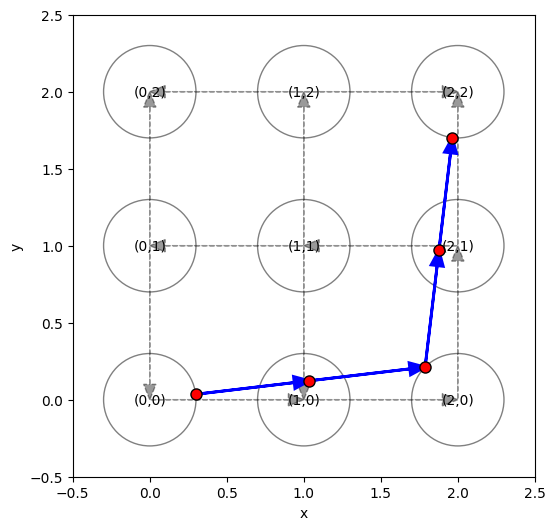

In [5]:

n = 3
radius = 0.3
Mv = 4.0  # big-M for vertex disks
Me = 1.0  # big-M for edge distances
solve_integer = False

# Vertex coordinates and indexing
tile_coords = [(i, j) for i in range(n) for j in range(n)]
V = len(tile_coords)
idx = {coord: k for k, coord in enumerate(tile_coords)}

edge_list = [
    ((0,0),(1,0)), ((1,0),(2,0)), ((2,0),(2,1)),
    ((0,1),(0,0)), ((0,1),(0,2)),
    ((1,1),(1,0)), ((1,1),(0,1)), ((1,1),(1,2)),
    ((2,1),(1,1)), ((2,1),(2,2)),
    ((1,2),(0,2)), ((1,2),(2,2)),
]
E = len(edge_list)

#---------------------------------------------------------------------------
# Decision variables
#---------------------------------------------------------------------------
x = cp.Variable((V, 2), name="x")            # visit points
z_v = cp.Variable(V, boolean=solve_integer, name="z_v")          # tile-use flags
z_e = cp.Variable(E, boolean=solve_integer, name="z_e")          # edge-use flags
d  = cp.Variable(E, nonneg=True, name="d")  # edge distances

#---------------------------------------------------------------------------
# Build constraints
#---------------------------------------------------------------------------
constraints = []
# Vertex (tile) constraints
for k, (i, j) in enumerate(tile_coords):
    constraints += [z_v[k] >= 0, z_v[k] <= 1]
    constraints.append(
        cp.norm(x[k] - np.array([i, j])) \
        <= radius + Mv * (1 - z_v[k])
    )

# Edge constraints
cost_terms = []
for e_idx, ((i1, j1), (i2, j2)) in enumerate(edge_list):
    u = idx[(i1, j1)]
    v = idx[(i2, j2)]
    constraints += [z_e[e_idx] >= 0, z_e[e_idx] <= 1]
    # distance coupling
    constraints.append(
        d[e_idx] >= cp.norm(x[v] - x[u]) - Me * (1 - z_e[e_idx])
    )
    constraints.append(
        d[e_idx] <= Me * z_e[e_idx]
    )
    # logical coupling
    constraints += [
        z_e[e_idx] <= z_v[u],
        z_e[e_idx] <= z_v[v],
        z_e[e_idx] >= z_v[u] + z_v[v] - 1
    ]
    cost_terms.append(d[e_idx])

# Flow conservation
start = (0, 0)
goal  = (n-1, n-1)
for k, coord in enumerate(tile_coords):
    inflow  = sum(z_e[i] for i, e in enumerate(edge_list) if e[1] == coord)
    outflow = sum(z_e[i] for i, e in enumerate(edge_list) if e[0] == coord)
    if coord == start:
        constraints.append(outflow - inflow == 1)
    elif coord == goal:
        constraints.append(inflow - outflow == 1)
    else:
        constraints.append(inflow - outflow == 0)

objective = cp.Minimize(cp.sum(cost_terms))

#---------------------------------------------------------------------------
# Solve
#---------------------------------------------------------------------------
problem = cp.Problem(objective, constraints)
result  = problem.solve(solver=cp.MOSEK, verbose=True)
print("Optimal objective value:", result)

#---------------------------------------------------------------------------
# Plot solution 
#---------------------------------------------------------------------------
plt.figure(figsize=(6,6))
ax = plt.gca()

# Draw disks and node labels
for i, j in tile_coords:
    circle = plt.Circle((i, j), radius, fill=False, color='gray', linewidth=1)
    ax.add_patch(circle)
    plt.text(i, j, f"({i},{j})", ha='center', va='center')

for (i1, j1), (i2, j2) in edge_list:
    dx, dy = i2 - i1, j2 - j1
    ax.arrow(i1, j1, dx, dy,
             length_includes_head=True,
             head_width=0.08,     
             head_length=0.1,   
             linestyle='--',
             color='black',
             linewidth=1,
             alpha=0.4)

# Overlay chosen path edges in solid blue arrows
for e_idx, ((i1, j1), (i2, j2)) in enumerate(edge_list):
    if z_e[e_idx].value > 0.5:
        u, v = idx[(i1, j1)], idx[(i2, j2)]
        p1 = x[u].value
        p2 = x[v].value
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        ax.arrow(p1[0], p1[1], dx, dy,
                 length_includes_head=True,
                 head_width=0.08,   
                 head_length=0.1,   
                 color='blue',
                 linewidth=2)

# Highlight chosen vertices in red
for k, (i, j) in enumerate(tile_coords):
    if z_v[k].value > 0.5:
        px, py = x[k].value
        ax.plot(px, py, 'ro', markersize=8, markeredgecolor='k')

ax.set_aspect('equal')
plt.xlim(-0.5, n-0.5)
plt.ylim(-0.5, n-0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
